In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 데이터 준비

In [2]:
# -------------------------------------------------
# data 불러오기
# -------------------------------------------------
df = pd.read_csv('data/bike_sharing_demand.csv', parse_dates=['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 전처리

### 파생컬럼 추가

In [3]:
# --------------------------------------------
# 연, 월, 시, 요일
# --------------------------------------------
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek # 월요일:0, 일요일:6
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


### 변수 선택

In [4]:
# --------------------------------------------
# 독립변수, 종속변수선택
# --------------------------------------------

# 독립변수에 사용하지 않을 컬럼
del_cols = ['datetime','casual','registered','count','temp'] 

X = df.drop(del_cols, axis=1).copy()
y = df['count']

X.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,0,1,14.395,81,0.0,2011,1,0,5
1,1,0,0,1,13.635,80,0.0,2011,1,1,5
2,1,0,0,1,13.635,80,0.0,2011,1,2,5
3,1,0,0,1,14.395,75,0.0,2011,1,3,5
4,1,0,0,1,14.395,75,0.0,2011,1,4,5


In [5]:
# ------------------------------------------------
# 독립변수 - 범주형, 수치형, 순환형 변수 구분
# ------------------------------------------------
cat_cols = ['season','holiday','workingday','weather']      
num_cols = ['atemp','humidity','windspeed', 'year']
cycle_cols = ['month', 'hour', 'dayofweek']

#### 순환형 데이터 인코딩

In [6]:
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

X['dayofweek_sin'] = np.sin(2 * np.pi * X['dayofweek'] / 7)
X['dayofweek_cos'] = np.cos(2 * np.pi * X['dayofweek'] / 7)


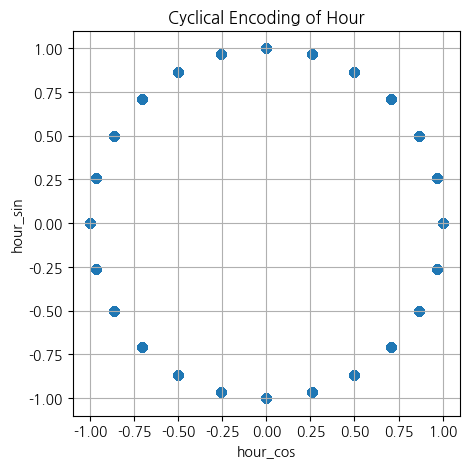

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(X['hour_cos'], X['hour_sin'])
plt.title('Cyclical Encoding of Hour')
plt.xlabel('hour_cos')
plt.ylabel('hour_sin')
plt.grid(True)
plt.show()

### 훈련세트 테스트세트 분할

In [ ]:
# -------------------------
# 훈련세트/테스트세트 분할
# -------------------------


(8164, 17) (2722, 17) (8164,) (2722,)


### 수치형 변수 스케일링

In [ ]:
# -------------------------
#   스케일링
# -------------------------


# -------------------------
#   데이터프레임으로 변환
# -------------------------

### 범주형 변수 원핫인코딩

In [ ]:
# -------------------------
#   원핫인코딩
# -------------------------


# -------------------------
#   생성된 열 이름
# -------------------------


# -------------------------
#   DataFrame으로 변환
# -------------------------



### 훈련에 사용할 최종 데이터 만들기

In [ ]:
cycle_cols = ['hour_sin','hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']


# LinearRegression

In [ ]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn._______ import _______
model = _______()
model.fit(_______, y_train)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')

# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

r2:0.5056727637202971
rmse:127.36119405709947
mae:92.56940620538272
mse:16220.87375165015
train>>>>>>>>>>>> 0.5131849258621071
test>>>>>>>>>>>>> 0.5056727637202971


# DecisionTreeRegressor

In [ ]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn._______ import _______
model = _______(random_state=42)
model.fit(_______, _______)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model._______(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

r2:0.8996341877199002
rmse:57.38821994443536
mae:34.6208670095518
mse:3293.407788390889
train>>>>>>>>>>>> 0.9999967687295567
test>>>>>>>>>>>>> 0.8996341877199002


# RandomForestRegressor

In [ ]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn._______ import _______
model = _______(random_state=42)
model.fit(_______, _______)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(_______)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(_______, _______)
rmse = root_mean_squared_error(_______, _______)
mae = mean_absolute_error(_______, _______)
mse = mean_squared_error(_______, _______)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(_______, _______))
print('test>>>>>>>>>>>>>', model.score(_______, _______))

r2:0.9528438894134199
rmse:39.336783085841866
mae:24.57365295126133
mse:1547.3825035425748
train>>>>>>>>>>>> 0.9922324356774103
test>>>>>>>>>>>>> 0.9528438894134199
